ModuleNotFoundError: No module named 'flax'

In [27]:
!pip install flax


   ---------------------------------------- 0.0/731.3 kB ? eta -:--:--
   --------- ------------------------------ 174.1/731.3 kB 5.1 MB/s eta 0:00:01
   ---------------------------- ----------- 522.2/731.3 kB 8.1 MB/s eta 0:00:01
   ---------------------------------------  727.0/731.3 kB 7.6 MB/s eta 0:00:01
   ---------------------------------------- 731.3/731.3 kB 5.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/240.7 kB ? eta -:--:--
   ---------------------------------------  235.5/240.7 kB ? eta -:--:--
   ---------------------------------------- 240.7/240.7 kB 2.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/75.3 kB ? eta -:--:--
   -------------------------------------- - 71.7/75.3 kB ? eta -:--:--
   ---------------------------------------- 75.3/75.3 kB 1.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/223.7 kB ? eta -:--:--
   ---------------------------------------- 223.7/223.7 kB 6.7 MB/s eta 0:00:00
   ------------

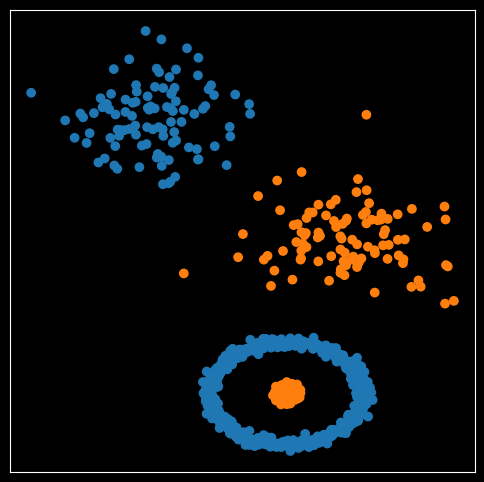

RuntimeError: Could not infer dtype of numpy.int64

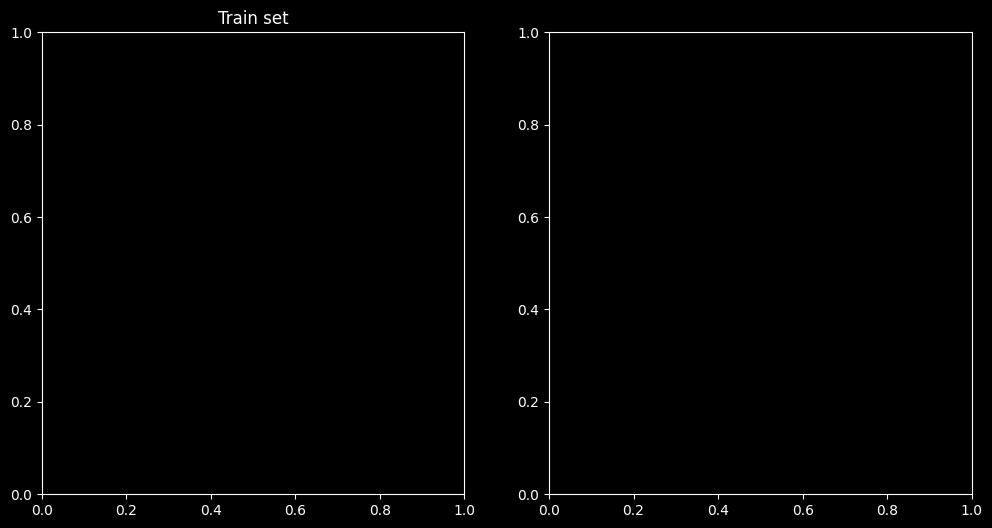

In [30]:
 #Standard libraries
import numpy as np
import seaborn as sns
import pandas as pd
import torch
from torch.utils import data

# Plotting libraries
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from IPython.display import Javascript  # Restrict height of output cell.

# jax
import jax
import jax.numpy as jnp
from jax.tree_util import tree_map
import flax
from flax import linen as nn
from flax.training import train_state
import optax

# scikit-learn
from sklearn.datasets import (make_blobs, make_circles)
from sklearn.model_selection import train_test_split

random_seed = 42
plt.style.use('dark_background')
plot_colors = cm.tab10.colors
batch_size = 32

# TOY DATASET 
class ToyDataset(data.Dataset):

  def __init__(self, size, seed):
    super().__init__()
    self.size = size
    self.np_rng = np.random.RandomState(seed=seed)
    self.make_nested_classes()

  def make_nested_classes(self):
    X, y = make_blobs(n_samples=int(self.size*0.2), n_features=2, centers=2, cluster_std=1.9, random_state=random_seed)
    X1, y1 = make_circles(n_samples=(int(self.size*0.6), int(self.size*0.2)), noise=0.05, factor=0.1, random_state=random_seed)
    # increase the radius
    X1 = X1*3
    # move along the x-axis
    X1[:,0] = X1[:,0]+2.5
    # move along the y-axis
    X1[:,1] = X1[:,1]-7

    X = np.concatenate((X, X1), axis=0)
    y = np.concatenate((y, y1), axis=0)

    self.data = X
    self.label = y

  def __len__(self):
    return self.size

  def __getitem__(self, idx):
    data_point = self.data[idx]
    data_label = self.label[idx]
    return data_point, data_label

dataset = ToyDataset(size=1000, seed=random_seed)
dataset

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(dataset.data[:,0], dataset.data[:,1], marker='o', color=np.array(plot_colors)[dataset.label])

ax.tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,
            labelbottom=False,labeltop=False,labelleft=False,labelright=False);
ax.set(xlabel=None, ylabel=None)
plt.show()


# TRAIN/SPLITS
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = data.random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(random_seed))
     

def numpy_collate(batch):
    """A collate function to convert PyTorch tensors to NumPy arrays."""
    collated_batch = data.default_collate(batch)
    return {k: np.array(v) for k, v in collated_batch.items()}

train_data_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=numpy_collate)
test_data_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=numpy_collate)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].set_title('Train set')
for batch in train_data_loader:
    sample, label = batch
    axs[0].scatter(sample[:,0], sample[:,1], marker='o', color=np.array(plot_colors)[label])

axs[1].set_title('Test set')
for batch in test_data_loader:
    sample, label = batch
    axs[1].scatter(sample[:,0], sample[:,1], marker='o', color=np.array(plot_colors)[label])

for ax in axs:
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                   labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    ax.set(xlabel=None, ylabel=None)

plt.show()
     